## Setup

In [1]:
# Load packages
using DifferentialEquations
using Plots, StatsPlots
using CSV, DataFrames
using Turing
using LaTeXStrings
using XLSX
using Optim
using StatsBase
using Random
using KernelDensity
using ProgressMeter
using Distributions
using Measures

# Setup plots standard
Plots.default(fontfamily = ("computer modern"))

# Set seed 
Random.seed!(42)

TaskLocalRNG()

In [2]:
# Add rhs file
include("model_rhs.jl")
    
# Add parameter file
include("model_default_param.jl")

# Add treatment rhs
include("model_rhs_treatment.jl")

# Add function for calculating VAF
include("model_calc_VAF.jl")

# Add model for Turing inference - individual
include("model_infer_dynamics.jl")

# Add model for Turing inference - hierarchical
include("model_infer_dynamics_Hierarchical_Gibbs_DALIAH.jl")

model_infer_dynamics_Hierarchical_Gibbs_DALIAH

In [3]:
# Setup initial conditions for master curve
x00 = 1.0*10^5
x10 = 2.5*10^6
x20 = 6.4*10^11
y00 = 1
y10 = 0
y20 = 0
a0 = 8.1*10^2
s0 = 1

# Collect in one vector
u0 = [x00,x10,x20,y00,y10,y20,a0,s0]

# Setup and solve ODEproblem
tspan = (0.0,90*365)
prob = ODEProblem(model_rhs, u0, tspan, p)
sol = solve(prob, TRBDF2(), reltol = 1e-10, abstol = 1e-10, saveat=1)

# Save as named tuple
master_curve = (t = sol.t, x0 = sol[1,:], x1 = sol[2,:], x2 = sol[3,:], y0 = sol[4,:], y1 = sol[5,:], y2 = sol[6,:], 
a = sol[7,:], s = sol[8,:], VAF = sol[6,:]./(sol[3,:]+sol[6,:]))

(t = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0  …  32841.0, 32842.0, 32843.0, 32844.0, 32845.0, 32846.0, 32847.0, 32848.0, 32849.0, 32850.0], x0 = [100000.0, 99999.28014604042, 99998.58099317514, 99997.90054517318, 99997.2361247567, 99996.58543544661, 99995.94650693233, 99995.31764842379, 99994.69740877306, 99994.0845423813  …  1.8609987268004509, 1.8600391708260122, 1.859080109644587, 1.8581215430323301, 1.8571634706299531, 1.8562058922481908, 1.855248807523938, 1.8542922162899567, 1.85333611836694, 1.8523805134158782], x1 = [2.5e6, 2.499892552031063e6, 2.4997848422058923e6, 2.4996769420471084e6, 2.4995689453848847e6, 2.4994609323745994e6, 2.4993529714592863e6, 2.4992451210456532e6, 2.4991374309370755e6, 2.499029943558893e6  …  58.85223884536521, 58.82189390263089, 58.791564607190864, 58.761250952072494, 58.73095292584728, 58.700670522809894, 58.67040373102239, 58.640152545142634, 58.609916959557594, 58.57969696360518], x2 = [6.4e11, 6.406571135075917e11, 6.412179399621925e11,

In [4]:
# Setup dataframes
df_D = DataFrame

# Load data
path = "M:/data_cancer/DALIAH/Trine_DALIAH_5y/DALIAH_5y - Export for Julia.csv"
df_D = CSV.read(path, df_D)

# Change data types
df_D[!,:days] = convert.(Float64,df_D[:,:days])
df_D[!,:RUX] = convert.(Float64,df_D[:,:RUX])


df_D

Row,patientID,days,IFN,RUX,JAK,TRC,WBC,studyVisit
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2,-22.0,0.0,0.0,NaN,NaN,6.3,-1.0
2,2,0.0,4.28571,0.0,0.49,300.0,7.9,0.0
3,2,14.0,4.28571,0.0,NaN,321.0,6.4,0.5
4,2,28.0,4.28571,0.0,NaN,211.0,6.1,1.0
5,2,56.0,4.28571,0.0,NaN,232.0,4.9,2.0
6,2,119.0,4.28571,0.0,0.46,225.0,5.4,4.0
7,2,182.0,4.28571,0.0,NaN,181.0,4.8,6.0
8,2,238.0,7.14286,0.0,0.32,161.0,4.0,8.0
9,2,294.0,7.14286,0.0,NaN,131.0,4.0,10.0


In [5]:
# Convert to starting at time for first data point - no matter if JAK or treatment
for i in unique(df_D.patientID)
    # Set pID
    pID = i
    
    # Extract minimum number of days - where IFN>0 or JAK>=0
    df_p = df_D[df_D.patientID .== pID,:]

    minDays = minimum(df_p.days[df_p.IFN .> 0  .|| df_p.JAK .>= 0, :])
    
    # Subtract minimum number of days
    df_D.days[df_D.patientID .== pID, :] = df_D.days[df_D.patientID .== pID, :] .- minDays
end
df_D

Row,patientID,days,IFN,RUX,JAK,TRC,WBC,studyVisit
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2,-22.0,0.0,0.0,NaN,NaN,6.3,-1.0
2,2,0.0,4.28571,0.0,0.49,300.0,7.9,0.0
3,2,14.0,4.28571,0.0,NaN,321.0,6.4,0.5
4,2,28.0,4.28571,0.0,NaN,211.0,6.1,1.0
5,2,56.0,4.28571,0.0,NaN,232.0,4.9,2.0
6,2,119.0,4.28571,0.0,0.46,225.0,5.4,4.0
7,2,182.0,4.28571,0.0,NaN,181.0,4.8,6.0
8,2,238.0,7.14286,0.0,0.32,161.0,4.0,8.0
9,2,294.0,7.14286,0.0,NaN,131.0,4.0,10.0


## Optimise multiple models and compare

In [6]:
# Setup list of models to compare
model_list = ["py0", "py1", "py0py1", "dy0", "dy1IFN", "dy0dy1", "py0dy0", "py0dy1", "dy0py1", "py1dy1"]

10-element Vector{String}:
 "py0"
 "py1"
 "py0py1"
 "dy0"
 "dy1IFN"
 "dy0dy1"
 "py0dy0"
 "py0dy1"
 "dy0py1"
 "py1dy1"

In [ ]:
# Setup list of models to compare
model_list = ["py0", "py1", "py0py1", "dy0", "dy1IFN", "dy0dy1", "py0dy0", "py0dy1", "dy0py1", "py1dy1"]

# Setup dataframe for storage
df_AIC_BIC = DataFrame(model = String[], Total_AIC = Float64[], Total_BIC = Float64[])

# Set boolean for plot
saveplot = true

# Optimise all models in loop
@showprogress dt=1 desc="Running MLE optimisation for all models..." for k in 1:length(model_list)
    # Choose treatment effect
    effect = model_list[k]
    
    # Extract number of parameterss
    if effect == "sy0dy1" || effect == "py0py1" || effect == "dy0dy1" || effect == "py0dy0" || effect == "py0dy1" || effect == "dy0py1" || effect == "py1dy1"
        n_param = 4
    elseif effect == "dy1" || effect == "py0" || effect == "py1" || effect == "dy0" || effect == "dy1IFN"
        n_param = 3
    end
    
    # Storage
    if n_param == 4
        df_MLE = DataFrame(patientID = Int64[], rho1 = Float64[], rho2 = Float64[], initJAK = Float64[], tau = Float64[], 
                           loglik = Float64[], AIC = Float64[], BIC = Float64[])
    elseif n_param == 3
        df_MLE = DataFrame(patientID = Int64[], rho1 = Float64[], initJAK = Float64[], tau = Float64[], loglik = Float64[],
                           AIC = Float64[], BIC = Float64[])
    end
        

    # Optimise in loop
    for i in unique(df_D.patientID)
        # Extract relevant data
        pID = i
        df_p = df_D[df_D.patientID .== pID, :]
        
        # Extract number of data points
        n = length(df_p.JAK)

        # Extract VAF - but remove NAN-observations
        pVAF = df_p.JAK
        pVAF = pVAF[.!isnan.(pVAF)]

        # Choose to estimate initial JAK
        estInitJAK = true

        # Instantiate model
        model = model_infer_dynamics(pVAF,df_p,effect,p,master_curve,estInitJAK)

        # Set seed 
        Random.seed!(42)

        # Storage
        if n_param == 4
            df_MLE_temp = DataFrame(patientID = Int64[], rho1 = Float64[], rho2 = Float64[], initJAK = Float64[], 
                                    tau = Float64[], loglik = Float64[], AIC = Float64[], BIC = Float64[])
        elseif n_param == 3
            df_MLE_temp = DataFrame(patientID = Int64[], rho1 = Float64[], initJAK = Float64[], 
                                    tau = Float64[], loglik = Float64[], AIC = Float64[], BIC = Float64[])
        end

        # Generate a MLE estimate - loop
       for j=1:10
            # Optimise likelihood
            mle_estimate = maximum_likelihood(model, ParticleSwarm(); maxiters = 100, allow_f_increases=true)

            # Setup temporary dataframe and save
            if n_param == 4
                df_temp = DataFrame(rho1 = coef(mle_estimate)[:rho1], rho2 = coef(mle_estimate)[:rho2],
                                    initJAK = coef(mle_estimate)[:initJAK], tau = coef(mle_estimate)[:tau])
            elseif n_param == 3
                df_temp = DataFrame(rho1 = coef(mle_estimate)[:rho1],
                                    initJAK = coef(mle_estimate)[:initJAK], tau = coef(mle_estimate)[:tau])
            end
            loglik = loglikelihood(model, df_temp)
            if n_param == 4
                df_temp = DataFrame(patientID = pID, rho1 = coef(mle_estimate)[:rho1], rho2 = coef(mle_estimate)[:rho2],
                                    initJAK = coef(mle_estimate)[:initJAK], tau = coef(mle_estimate)[:tau],
                                    loglik = loglik, AIC = 2*n_param-2*loglik, BIC = n_param*log(n)-2*loglik)
            elseif n_param == 3
                df_temp = DataFrame(patientID = pID, rho1 = coef(mle_estimate)[:rho1],
                                    initJAK = coef(mle_estimate)[:initJAK], tau = coef(mle_estimate)[:tau],
                                    loglik = loglik, AIC = 2*n_param-2*loglik, BIC = n_param*log(n)-2*loglik)
            end
            append!(df_MLE_temp, df_temp)
        end

        # Save best MLE
        push!(df_MLE, df_MLE_temp[argmax(df_MLE_temp.loglik),:])   
    
        # Save plots if wanted
        if saveplot
            # Extract relevant data
            pID = i
            df_p = df_D[df_D.patientID .== pID, :]
            
            # Extract latest data point
            maxDays = maximum(df_p.days)

            # Extract VAF - but remove NAN-observations
            pVAF = df_p.JAK
            pVAF = pVAF[.!isnan.(pVAF)]

            # Choose to estimate initial JAK
            estInitJAK = true

            # Choose time for calculating VAF
            pDays = collect(1:11*365)
            pDays2 = df_p.days[.!isnan.(df_p.JAK)]

            # Load standard parameters
            include("model_default_param.jl")

            # Extract MLE estimate
            df_MLE_p = df_MLE[df_MLE.patientID .== pID,:]
            if n_param == 4
                rho = [df_MLE_p.rho1[1], df_MLE_p.rho2[1]]
            elseif n_param == 3
                rho = df_MLE_p.rho1[1]
            end
            initJAK = df_MLE_p.initJAK[1]

            # Calculate VAF using function
            VAF_MLE, sol = model_calc_VAF(rho,df_p,effect,pDays,p,master_curve,initJAK)
            VAF_MLE_points, sol = model_calc_VAF(rho,df_p,effect,pDays2,p,master_curve,initJAK)

            # Calculate RMSE
            RMSE = rmsd(VAF_MLE_points,pVAF)

            # Plot results
            figVAF = plot(pDays[pDays.<=maxDays]/30.4, VAF_MLE[pDays.<=maxDays]*100, linewidth = 3, label = L"JAK2"*" VAF - MLE", colour= :green1)
            plot!(pDays[pDays.>maxDays]/30.4, VAF_MLE[pDays.>maxDays]*100, linewidth = 3, label = L"JAK2"*" VAF - MLE", colour= :green1, linestyle = :dash)
            # plot!(pDays/30.4, VAF_true*100, linewidth = 3, label = L"JAK2"*" VAF - True", colour = :darkgoldenrod2)
            scatter!(df_p.days./30.4, df_p.JAK*100, label=L"\textrm{Data}", markercolor=:red, markersize=4)
            if n_param == 4
                title!(L"JAK2"*" VAF for Patient $(pID), RMSE = $(round(RMSE; sigdigits=3)),\n"*L"\rho_{p_{y_0}}="
                       *"$(round(df_MLE_p.rho1[1]; sigdigits=3)), " * L"\rho_{p_{y_1}}="*"$(round(df_MLE_p.rho2[1]; sigdigits=3))")
            elseif n_param == 3
                title!(L"JAK2"*" VAF for Patient $(pID), RMSE = $(round(RMSE; sigdigits=3)),\n"*L"\rho_{p_{y_0}}="
                       *"$(round(df_MLE_p.rho1[1]; sigdigits=3))")
            end
            xlabel!(L"t"*"/months")
            ylabel!(L"JAK2"*" VAF/%")
            t_end = 125
            xlims!(0, t_end)
            ylims!(0,100)
            plot!(titlefont=20,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=10, 
                legend = :none)
            figIFN = plot(df_p.days/30.4, df_p.IFN, line =:steppost, linewidth = 3, label = "", colour= :blue1)
            plot!([maxDays/30.4,120], [df_p.IFN[end],df_p.IFN[end]], line =:steppost, linewidth = 3, label = "", colour= :blue1,
                   linestyle = :dash)
            title!("IFN Dose for Patient $(pID)")
            xlabel!(L"t"*"/months")
            ylabel!("IFN/"*L"\mathrm{\frac{\mu g}{day}}")
            xlims!(0, t_end)
            ylims!(0, 20)
            plot!(titlefont=20,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=10)
            figcombined = plot(figVAF,figIFN, layout=grid(2,1, heights=(7/10, 3/10)), link =:x, size = (700, 500), margin=5mm)

            # Save figure
            figpath = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Billeder og video/DALIAH_5y Data - Patient Plots/Individual/MLE/$(effect)/"
            savefig(figcombined,figpath*"MLE_$(effect)_p$(pID).png")
            savefig(figcombined,figpath*"MLE_$(effect)_p$(pID).pdf")
            savefig(figcombined,figpath*"MLE_$(effect)_p$(pID).svg")
        end
    end
    
    # Write results to CSV file
    path = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Excel/DALIAH_5y Data - MLE files/MLE_$(effect).csv"
    CSV.write(path, df_MLE)
    
    # Save sum of BICs in dataframe
    df_temp = DataFrame(model = effect, Total_AIC = sum(df_MLE.AIC), Total_BIC = sum(df_MLE.BIC))
    append!(df_AIC_BIC, df_temp)
end

# Save df_AIC_BIC
path = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Excel/DALIAH_5y Data - MLE files/Total_AIC_BIC.csv"
CSV.write(path, df_AIC_BIC)

In [7]:
# Load df_AIC_BIC
df_AIC_BIC = DataFrame
path = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Excel/DALIAH_5y Data - MLE files/Total_AIC_BIC.csv"
df_AIC_BIC = CSV.read(path, df_AIC_BIC)

Row,model,Total_AIC,Total_BIC
,String7,Float64,Float64
1,py0,-1394.08,-1195.44
2,py1,-711.404,-512.759
3,py0py1,-1830.95,-1566.08
4,dy0,-1644.39,-1445.75
5,dy1IFN,-759.335,-560.689
6,dy0dy1,-1914.8,-1649.94
7,py0dy0,-1562.27,-1297.41
8,py0dy1,-1936.73,-1671.87
9,dy0py1,-1940.44,-1675.58


In [8]:
# Calculate relative likelihood - does not make sense for the sum of likelihoods
df_AIC_BIC.relLik = exp.((minimum(df_AIC_BIC.Total_AIC).-df_AIC_BIC.Total_AIC)/2)
df_AIC_BIC

Row,model,Total_AIC,Total_BIC,relLik
,String7,Float64,Float64,Float64
1,py0,-1394.08,-1195.44,2.28918e-119
2,py1,-711.404,-512.759,1.31262e-267
3,py0py1,-1830.95,-1566.08,1.67308e-24
4,dy0,-1644.39,-1445.75,5.17146e-65
5,dy1IFN,-759.335,-560.689,3.35822e-257
6,dy0dy1,-1914.8,-1649.94,2.70789e-6
7,py0dy0,-1562.27,-1297.41,7.59425e-83
8,py0dy1,-1936.73,-1671.87,0.156419
9,dy0py1,-1940.44,-1675.58,1.0


In [9]:
# Storage
df_AIC_all = DataFrame(patientID = unique(df_D.patientID))
df_BIC_all = DataFrame(patientID = unique(df_D.patientID))
    
# Extract AIC and BIC for a single patient
for k in 1:length(model_list)
     # Choose treatment effect
    effect = model_list[k]

    # Load results
    df_MLE = DataFrame
    path = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Excel/DALIAH_5y Data - MLE files/MLE_$(effect).csv"
    df_MLE = CSV.read(path, df_MLE)
    
    temp_AIC = []
    temp_BIC = []

    for i in unique(df_D.patientID)
        # Set pID
        pID = i

        # Extract AIC and BIC
        df_MLE_temp = df_MLE[df_MLE.patientID .== pID,:]
        append!(temp_AIC,df_MLE_temp.AIC)
        append!(temp_BIC,df_MLE_temp.BIC)
    end
    
    # Put in dataframe
    df_AIC_all[!, "$(effect)"] = temp_AIC
    df_BIC_all[!, "$(effect)"] = temp_BIC
end
df_AIC_all

Row,patientID,py0,py1,py0py1,dy0,dy1IFN,dy0dy1,py0dy0,py0dy1,dy0py1,py1dy1
,Int64,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any
1,2,-9.00075,6.26952,-40.4641,-22.4596,6.4644,-43.9821,-20.4597,-39.165,-49.6081,8.26936
2,3,-6.97288,4.07803,-22.5238,-20.0132,1.35278,-30.7569,-18.0132,-31.208,-27.1305,3.35281
3,4,-16.3977,-6.55622,-29.2897,-22.2787,-4.22301,-28.089,-20.2744,-29.0868,-27.7186,-4.55012
4,6,-25.8964,-22.1309,-34.1624,-30.0679,-20.4766,-52.0006,-28.0664,-54.3019,-45.8815,-20.1311
5,11,-18.079,-16.8162,-26.6106,-24.1358,-16.0188,-35.9492,-22.1358,-34.5794,-45.4212,-14.816
6,14,-7.53321,-10.2016,-15.5239,-11.1077,-8.48626,-9.72997,-9.10682,-9.87337,-20.1743,-8.21958
7,16,-17.2984,-0.0822131,-39.9832,-24.1293,-4.34113,-41.5204,-22.1302,-44.1602,-40.2163,-2.34113
8,20,-17.6591,4.77687,-33.3701,-26.7185,3.48577,-26.8046,-24.7226,-26.1243,-25.1119,5.41247
9,22,-18.4237,-18.8533,-16.8552,-18.4229,-19.4345,-17.4198,-16.4238,-17.4285,-16.8635,-17.4302


In [10]:
# Storage
df_relLik_all = copy(df_AIC_all)
df_relLik_BIC_all = copy(df_BIC_all)

for i=1:size(df_AIC_all)[1]
    for j=2:size(df_AIC_all)[2]
        # Calculate relative likelihood and save
        df_relLik_all[i,j] = exp((minimum(df_AIC_all[i,:])-df_AIC_all[i,j])/2)
        df_relLik_BIC_all[i,j] = exp((minimum(df_BIC_all[i,:])-df_BIC_all[i,j])/2)
    end
end
df_relLik_all

Row,patientID,py0,py1,py0py1,dy0,dy1IFN,dy0dy1,py0dy0,py0dy1,dy0py1,py1dy1
,Int64,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any
1,2,1.52132e-9,7.3506e-13,0.0103372,1.27281e-6,6.66815e-13,0.060023,4.68271e-7,0.00539882,1.0,2.70435e-13
2,3,5.46275e-6,2.17639e-8,0.0130093,0.00370749,8.50188e-8,0.798078,0.00136391,1.0,0.130193,3.12763e-8
3,4,0.00158684,1.15743e-5,1.0,0.0300316,3.60449e-6,0.548633,0.0110247,0.903538,0.455875,4.24498e-6
4,6,6.78922e-7,1.03313e-7,4.23402e-5,5.4658e-6,4.51789e-8,0.316435,2.00926e-6,1.0,0.0148434,3.80106e-8
5,11,1.15536e-6,6.14492e-7,8.22904e-5,2.38745e-5,4.12438e-7,0.00877371,8.78316e-6,0.00442318,1.0,2.26037e-7
6,14,0.00179898,0.00683066,0.0977659,0.0107452,0.0028972,0.00539568,0.00395121,0.00579675,1.0,0.00253553
7,16,1.46902e-6,2.68277e-10,0.123873,4.47027e-5,2.25629e-9,0.267165,1.64532e-5,1.0,0.139185,8.30044e-10
8,20,0.000387632,5.20596e-9,1.0,0.0359437,9.92795e-9,0.0375257,0.0132505,0.0267052,0.0160981,3.78862e-9
9,22,0.603272,0.747797,0.275359,0.603027,1.0,0.365178,0.221939,0.36677,0.276512,0.36709


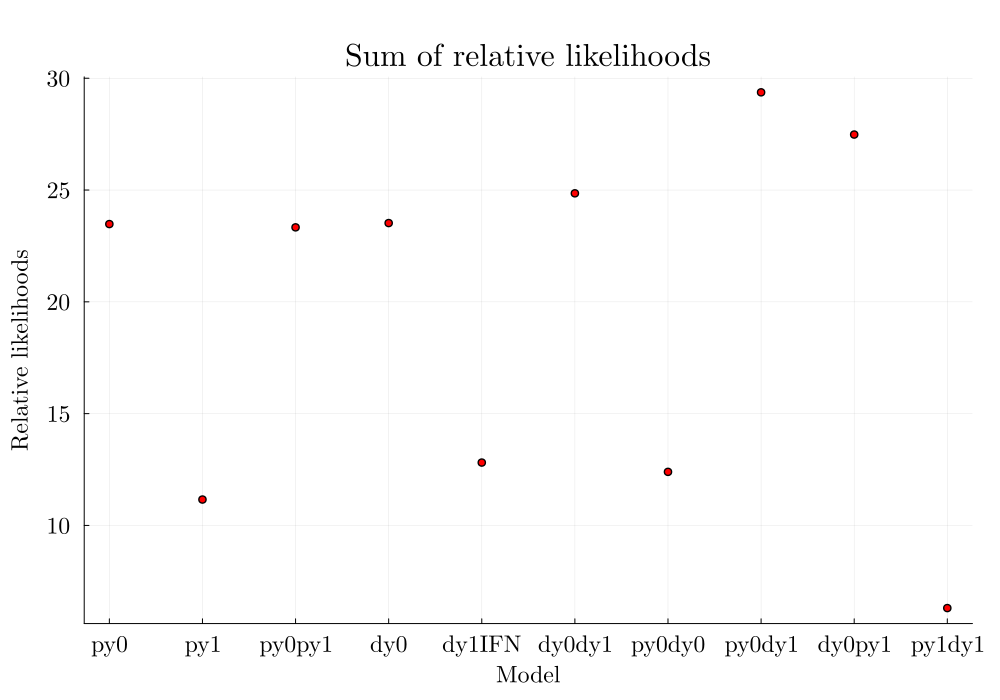

In [11]:
# Sum of relative likelihoods
sum_rel_lik = vec(sum(Matrix(df_relLik_all[:,2:end]),dims=1))
scatter(sum_rel_lik, markercolor=:red, markersize=4, xticks = (1:10, model_list), label = "")
title!("\nSum of relative likelihoods")
xlabel!("Model")
ylabel!("Relative likelihoods")
# xlims!(0.5, 10.5)
plot!(titlefont=20,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=10,size = (1000, 700),
      margin=5mm)

In [12]:
# x ticks
model_list_plot = [L"p_{y_0}", L"p_{y_1}", L"p_{y_0}, "*L"p_{y_1}", L"d_{y_0}", L"d_{y_1}", L"d_{y_0}, "*L"d_{y_1}", 
                   L"p_{y_0}, "*L"d_{y_0}", L"p_{y_0}, "*L"d_{y_1}", L"d_{y_0}, "*L"p_{y_1}", L"p_{y_1}, "*L"d_{y_1}"]

# Number of "good models" (relative likelihood greater than a threshold)
threshold = 0.2
sum_good_model = vec(sum(Matrix(df_relLik_all[:,2:end]).>threshold,dims=1))
fig_relLik = scatter(sum_good_model, markercolor=:red, markersize=4, xticks = (1:10, model_list_plot), label = "")
title!("\nNumber of patients for which the model\n has a relative likelihood above 0.2")
xlabel!("Model")
ylabel!("Number of patients")
xlims!(0.5, 10.5)
ylims!(0, 64)
plot!(titlefont=20,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=10,size = (1000, 700),
      margin=5mm)

# Save figure
figpath = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Billeder og video/DALIAH_5y Data - Patient Plots/Individual/MLE/"
savefig(fig_relLik,figpath*"relLik_comparison.png")
savefig(fig_relLik,figpath*"relLik_comparison.pdf")
savefig(fig_relLik,figpath*"relLik_comparison.svg")

"C:\\Users\\boklund\\Documents\\Egne artikler m.m\\IFN-artikel 2024\\Billeder og video\\DALIAH_5y Data - Patient Plots\\Individual\\MLE\\relLik_comparison.svg"

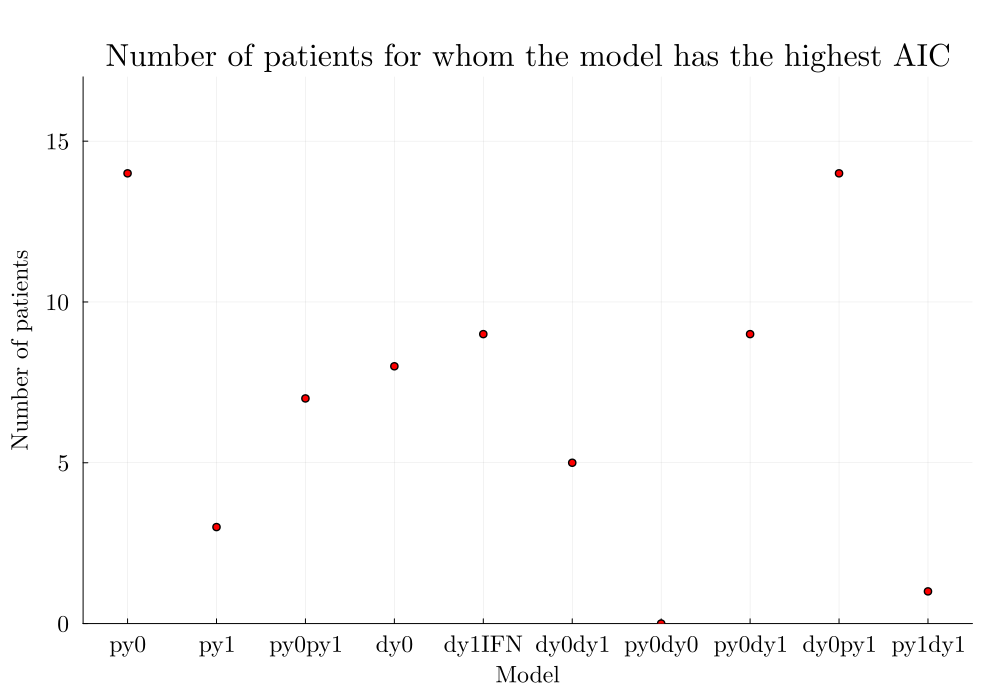

In [13]:
# Number of best models
threshold = 1.0
sum_best_model = vec(sum(Matrix(df_relLik_all[:,2:end]).>=threshold,dims=1))
scatter(sum_best_model, markercolor=:red, markersize=4, xticks = (1:10, model_list), label = "")
title!("\nNumber of patients for whom the model has the highest AIC")
xlabel!("Model")
ylabel!("Number of patients")
xlims!(0.5, 10.5)
ylims!(0, 17)
plot!(titlefont=20,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=10,size = (1000, 700),
      margin=5mm)

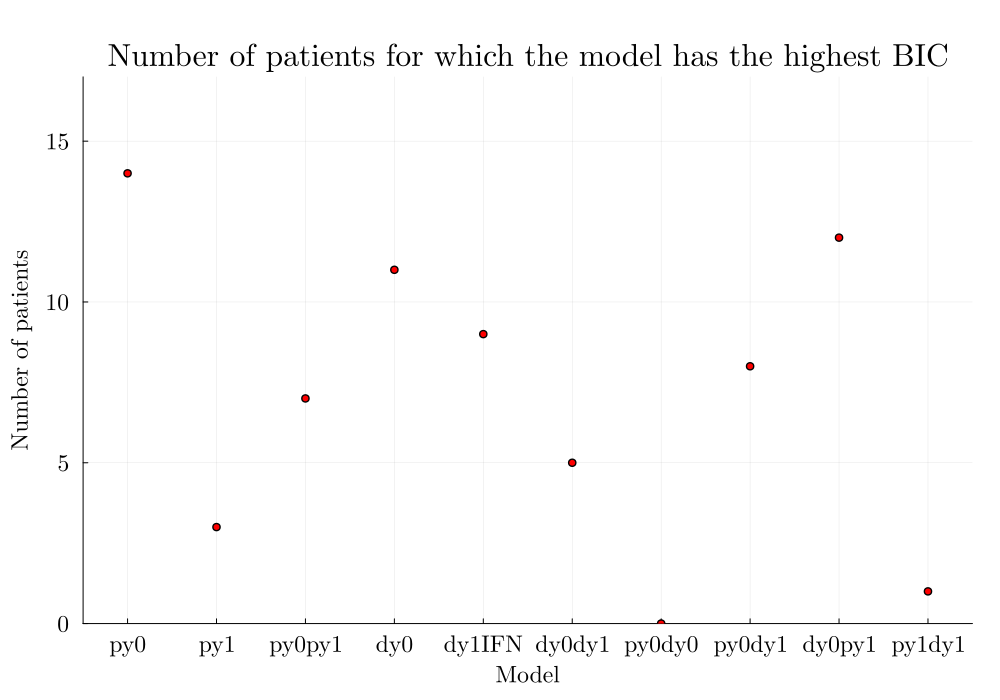

In [14]:
# Number of best models - BIC
threshold = 1.0
sum_best_model = vec(sum(Matrix(df_relLik_BIC_all[:,2:end]).>=threshold,dims=1))
scatter(sum_best_model, markercolor=:red, markersize=4, xticks = (1:10, model_list), label = "")
title!("\nNumber of patients for which the model has the highest BIC")
xlabel!("Model")
ylabel!("Number of patients")
xlims!(0.5, 10.5)
ylims!(0, 17)
plot!(titlefont=20,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=10,size = (1000, 700),
      margin=5mm)

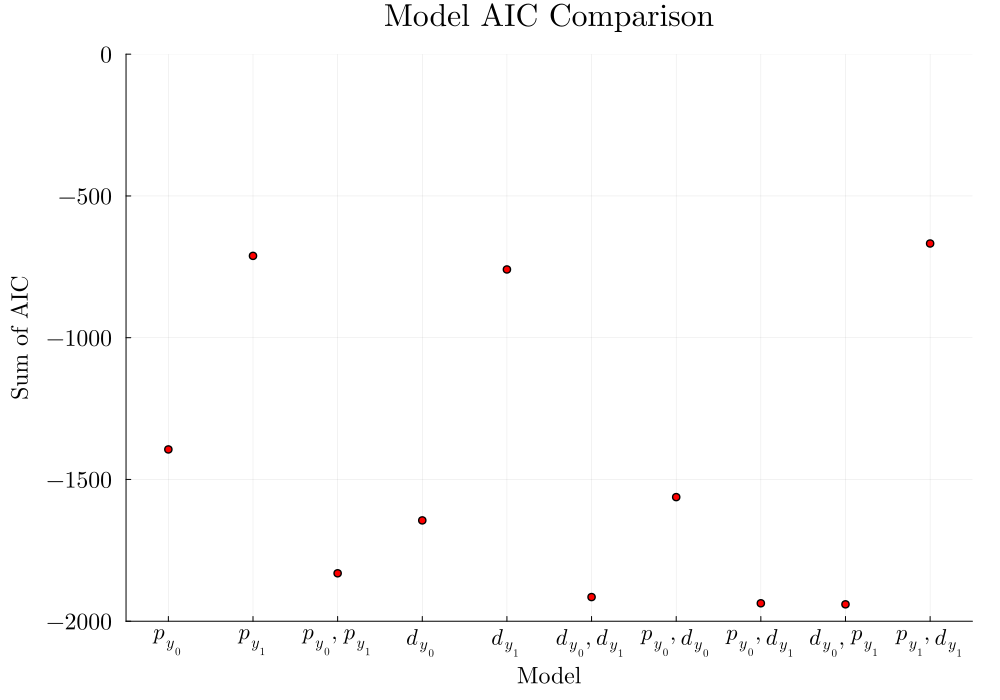

In [16]:
# Setup list of models to compare
model_list_plot = [L"p_{y_0}", L"p_{y_1}", L"p_{y_0}, "*L"p_{y_1}", L"d_{y_0}", L"d_{y_1}", L"d_{y_0}, "*L"d_{y_1}", 
                   L"p_{y_0}, "*L"d_{y_0}", L"p_{y_0}, "*L"d_{y_1}", L"d_{y_0}, "*L"p_{y_1}", L"p_{y_1}, "*L"d_{y_1}"]

# Plot results
fig_AIC = scatter(df_AIC_BIC.Total_AIC,label="", markercolor=:red, markersize=4, xticks = (1:10, model_list_plot))
title!("Model AIC Comparison")
xlabel!("Model")
ylabel!("Sum of AIC")
xlims!(0.5, 10.5)
ylims!(-2000,0)
plot!(titlefont=20,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=10,size = (1000, 700),
      margin=5mm)

# Save figure
figpath = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Billeder og video/DALIAH_5y Data - Patient Plots/Individual/MLE/"
savefig(fig_AIC,figpath*"AIC_comparison.png")
savefig(fig_AIC,figpath*"AIC_comparison.pdf")
savefig(fig_AIC,figpath*"AIC_comparison.svg")

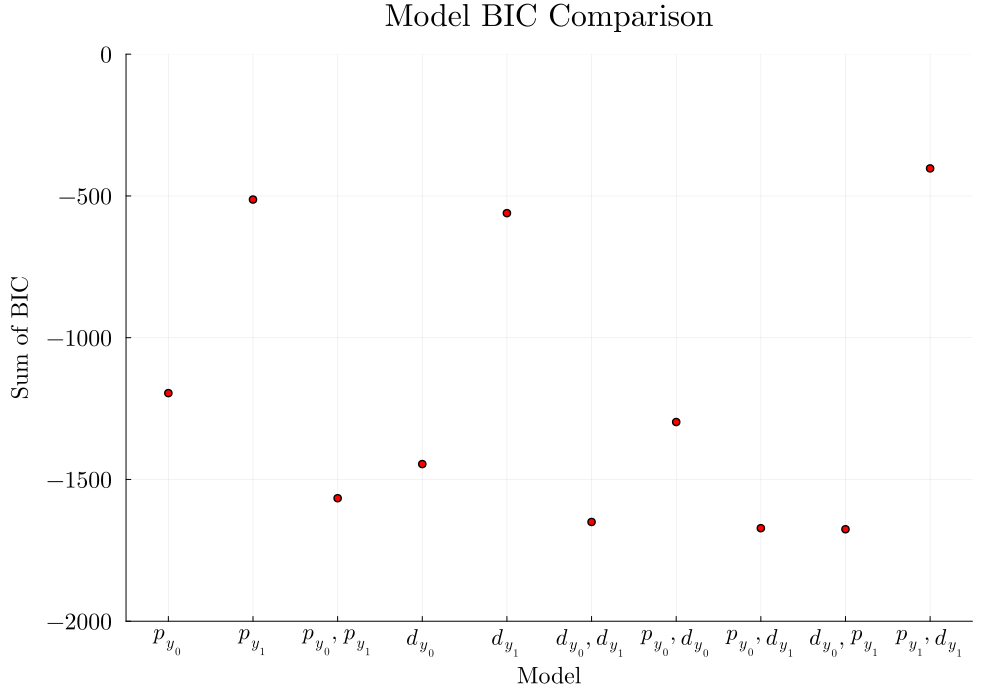

In [17]:
# Setup list of models to compare
model_list_plot = [L"p_{y_0}", L"p_{y_1}", L"p_{y_0}, "*L"p_{y_1}", L"d_{y_0}", L"d_{y_1}", L"d_{y_0}, "*L"d_{y_1}", 
                   L"p_{y_0}, "*L"d_{y_0}", L"p_{y_0}, "*L"d_{y_1}", L"d_{y_0}, "*L"p_{y_1}", L"p_{y_1}, "*L"d_{y_1}"]

# Plot results
fig_BIC = scatter(df_AIC_BIC.Total_BIC,label="", markercolor=:red, markersize=4, xticks = (1:10, model_list_plot))
title!("Model BIC Comparison")
xlabel!("Model")
ylabel!("Sum of BIC")
xlims!(0.5, 10.5)
ylims!(-2000,0)
plot!(titlefont=20,xtickfontsize=15,ytickfontsize=15,xguidefontsize=15,yguidefontsize=15,legendfontsize=10,size = (1000, 700),
      margin=5mm)

# Save figure
figpath = "C:/Users/boklund/Documents/Egne artikler m.m/IFN-artikel 2024/Billeder og video/DALIAH_5y Data - Patient Plots/Individual/MLE/"
savefig(fig_BIC,figpath*"BIC_comparison.png")
savefig(fig_BIC,figpath*"BIC_comparison.pdf")
savefig(fig_BIC,figpath*"BIC_comparison.svg")